In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import pandasql as ps
import functools
from xgboost import XGBRegressor
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error

In [2]:
df_path = r"PS_Homework_data_set.csv"
df = pd.read_csv(df_path)
df.head()

,Unnamed: 0,advertiser_id,assigned,date_assignment_starts,date_assignment_ends,first_revenue_date,date_created,age,assign_days,revenue
0,0,485,1,2017-02-01 00:00:00.000000,2017-06-19 12:12:37.888680,NaN,2006-07-14,3855,138,NaN
1,1,598,1,2017-02-01 00:00:00.000000,2017-06-19 12:12:37.888680,NaN,2006-08-02,3836,138,NaN
2,2,673,1,2017-02-01 00:00:00.000000,2017-04-28 15:36:30.000000,NaN,2006-08-17,3821,86,NaN
3,3,813,1,2017-02-01 00:00:00.000000,2017-06-19 12:12:37.888680,NaN,2006-09-12,3795,138,NaN
4,4,1132,1,2017-02-01 00:00:00.000000,2017-06-19 12:12:37.888680,NaN,2006-11-02,3744,138,NaN


In [3]:
df.drop(['Unnamed: 0','advertiser_id','date_assignment_starts','date_assignment_ends'], axis=1, inplace=True)

In [4]:
# Converting columns containing dates into datetime type
date_columns = ['first_revenue_date', 'date_created']

for d in date_columns:
    df[d] = df[d].astype('datetime64[ns]')

In [5]:
df['year_created'] = df['date_created'].dt.year
#df['month_created'] = df['date_created'].dt.month
#df.drop(['year_created','month_created'],axis = 1, inplace=True)

In [6]:
df.set_index('date_created', inplace=True)

In [7]:
df

,assigned,first_revenue_date,age,assign_days,revenue,year_created
date_created,,,,,,
2006-07-14,1,NaT,3855,138,NaN,2006
2006-08-02,1,NaT,3836,138,NaN,2006
2006-08-17,1,NaT,3821,86,NaN,2006
2006-09-12,1,NaT,3795,138,NaN,2006
2006-11-02,1,NaT,3744,138,NaN,2006
...,...,...,...,...,...,...
2017-02-23,1,2017-02-23,-22,138,9643000.0,2017
2017-02-23,1,NaT,-22,138,NaN,2017
2017-02-24,1,NaT,-23,138,NaN,2017


In [8]:
q_assign_count ='SELECT COUNT("assigned"), year_created FROM df WHERE assigned == 1 GROUP BY year_created'
q_unassign_count ='SELECT COUNT("assigned"), year_created FROM df WHERE assigned == 0 GROUP BY year_created'
assigned_count_yearwise = ps.sqldf(q_assign_count, locals())
unassigned_count_yearwise = ps.sqldf(q_unassign_count, locals())


In [9]:
df_assigned_perc = functools.reduce(lambda  left,right: pd.merge(left,right,on=['year_created'],
                                            how='outer'), [assigned_count_yearwise, unassigned_count_yearwise]).fillna(0)

In [10]:
df_assigned_perc['yoy_assigned_ratio'] = (df_assigned_perc['COUNT("assigned")_x']
                                     /(df_assigned_perc['COUNT("assigned")_x']
                                       + df_assigned_perc['COUNT("assigned")_y']))*100

In [11]:
df_assigned_perc

,"COUNT(""assigned"")_x",year_created,"COUNT(""assigned"")_y",yoy_assigned_ratio
0,10,2006,0.0,100.000000
1,12,2007,0.0,100.000000
2,19,2008,1.0,95.000000
3,66,2009,4.0,94.285714
4,118,2010,1.0,99.159664
5,189,2011,2.0,98.952880
6,2870,2012,18.0,99.376731
7,4049,2013,76.0,98.157576
8,5648,2014,106.0,98.157803
9,9260,2015,253.0,97.340481


#### Resampling data

In [12]:
df_yearly_revenue = df.resample('Y')["revenue"].sum().to_frame()
df_yearly_assignedDays = df.resample('Y')["assign_days"].mean().to_frame()
df_yearly_age = df.resample('Y')["age"].mean().to_frame()

In [13]:
data_frames = [df_yearly_revenue,df_yearly_assignedDays, df_yearly_age]

In [14]:
df_workable = functools.reduce(lambda  left,right: pd.merge(left,right,on=['date_created'],
                                            how='outer'), data_frames).fillna(0)

In [15]:
df_workable.reset_index(inplace=True)

In [16]:
df_workable['year_created'] = df_workable['date_created'].dt.year

In [17]:
df_workable

,date_created,revenue,assign_days,age,year_created
0,2006-12-31,0.000000e+00,132.800000,3765.000000,2006
1,2007-12-31,7.071000e+08,138.000000,3480.583333,2007
2,2008-12-31,5.000000e+08,131.500000,3127.550000,2008
3,2009-12-31,1.863880e+08,118.071429,2713.742857,2009
4,2010-12-31,9.933870e+08,114.815126,2398.605042,2010
5,2011-12-31,4.445733e+09,121.643979,2034.973822,2011
6,2012-12-31,1.102868e+10,131.961911,1605.822715,2012
7,2013-12-31,9.579315e+09,127.228848,1309.824970,2013
8,2014-12-31,2.088561e+10,124.190650,942.147028,2014
9,2015-12-31,2.589168e+10,121.086093,578.382529,2015


In [18]:
df_workable = functools.reduce(lambda  left,right: pd.merge(left,right,on=['year_created'],
                                            how='outer'), [df_workable,df_assigned_perc]).fillna(0)

In [19]:
df_workable.drop(['year_created','COUNT("assigned")_x','COUNT("assigned")_y'], axis = 1, inplace=True)

In [20]:
df_workable

,date_created,revenue,assign_days,age,yoy_assigned_ratio
0,2006-12-31,0.000000e+00,132.800000,3765.000000,100.000000
1,2007-12-31,7.071000e+08,138.000000,3480.583333,100.000000
2,2008-12-31,5.000000e+08,131.500000,3127.550000,95.000000
3,2009-12-31,1.863880e+08,118.071429,2713.742857,94.285714
4,2010-12-31,9.933870e+08,114.815126,2398.605042,99.159664
5,2011-12-31,4.445733e+09,121.643979,2034.973822,98.952880
6,2012-12-31,1.102868e+10,131.961911,1605.822715,99.376731
7,2013-12-31,9.579315e+09,127.228848,1309.824970,98.157576
8,2014-12-31,2.088561e+10,124.190650,942.147028,98.157803
9,2015-12-31,2.589168e+10,121.086093,578.382529,97.340481


In [21]:
df_workable.set_index(['date_created'], inplace=True)

<AxesSubplot:>

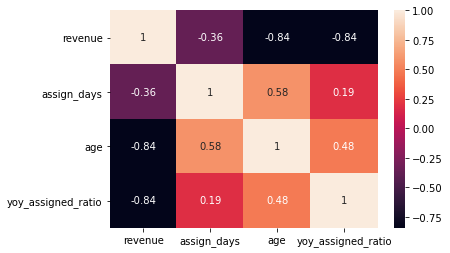

In [22]:
sns.heatmap(df_workable.corr(),annot=True)

### We can see that "assigned ratio" has a strong correlation of -0.84 with the target variable "revenue"

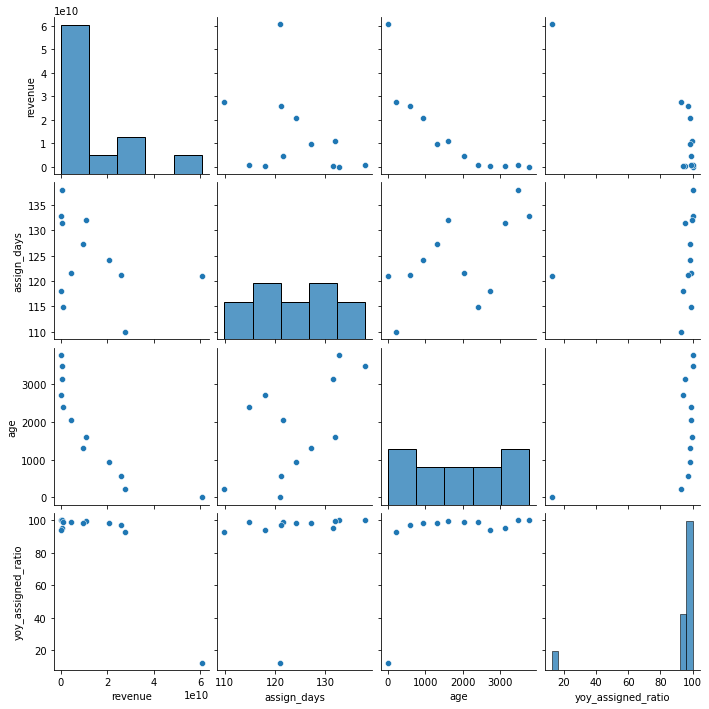

In [23]:
sns.pairplot(df_workable)

<AxesSubplot:xlabel='yoy_assigned_ratio', ylabel='revenue'>

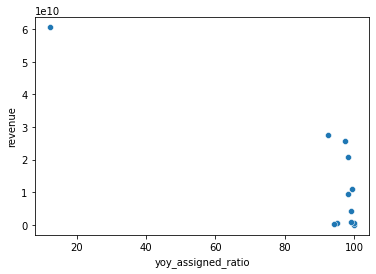

In [24]:
sns.scatterplot(x='yoy_assigned_ratio',y ='revenue', data = df_workable)

High Assigned lead percentage is generating more revenues

<AxesSubplot:xlabel='date_created'>

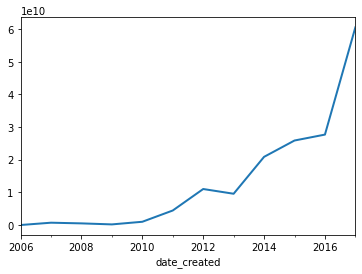

In [25]:
df_workable['revenue'].plot(linewidth=2)

Revenue is increasing year on year

<AxesSubplot:xlabel='date_created'>

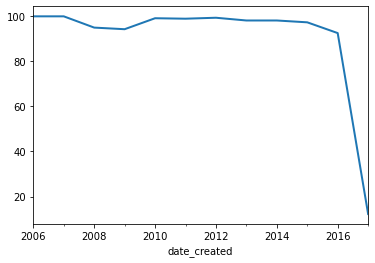

In [26]:
df_workable['yoy_assigned_ratio'].plot(linewidth=2)

Assigned ratio has significantly fell in the end of the year 2015

<AxesSubplot:xlabel='date_created'>

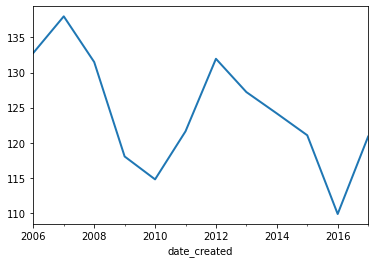

In [27]:
df_workable['assign_days'].plot(linewidth=2)

A bearish trend can been seen with the assign days. Number of assigned days is falling yearly though there was a rise after the year 2010 till the year 2012.

In [28]:
# Taking revenue as the target varianle and yoy_assigned_ratio as input feature to know its impact on revenue
X = df_workable['yoy_assigned_ratio']
y = df_workable['revenue']

In [29]:
X.corr(y)

-0.8371081148221126

### We can see that "assigned ratio" has a strong correlation of -0.84 with the target variable "revenue"